<a href="https://colab.research.google.com/github/friederrr/proof_contamination/blob/main/code/CDM_eval/cdm_accuracy_log_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**prod**
# CDMs Accuracy Summary to Excel/Overleaf
This notebook collects all relevant accuracy_logs files and converts it into a pandas_dataframe. It will calculate missing metrics (mean + std) and converts into a format which is then used to incorporate in a table in latex or excel.

In [ ]:
#1 mount
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#2 import
import random
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
from datetime import datetime
import itertools
from itertools import cycle, product
import re
from pathlib import Path
import statistics


In [ ]:
#3 list all json files
DRIVE_PATH=Path('/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1')

# List all JSON files recursively (in subfolders too, if needed)
json_files = list(DRIVE_PATH.rglob("*overleaf2.json"))

# OLMO extraction
# Keep only files that have 'OLMO' in the path
#olmo_files = [file for file in json_files if 'OLMo-7B' in str(file)]


# Print the list of file paths
for file in json_files:
    print(file)

/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/minK/MathCONTA_train_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/minK/MathCONTA_test_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ContaTraces/MathCONTA_full_train_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ContaTraces/MathCONTA_test_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/CDD/MathCONTA_train_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/CDD/MathCONTA_test_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ngram_acc/Ma

## Functions

In [ ]:
def load_test_accuracylog_to_dataframe(json_files):

    all_records = []

    for file_path in json_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
        except (json.JSONDecodeError, FileNotFoundError):
            continue  # überspringt fehlerhafte oder nicht vorhandene Dateien

        # Basisinformationen aus der JSON-Datei extrahieren
        model_id = data.get("model_id", "unknown_model")
        data_name = data.get("data_name", None)
        datetime_val = data.get("datetime", None)
        method_name = data.get("method_name", "unknown_method")
        parameter_dict = data.get("parameter", {})
        metrics = data.get("metrics", {})

        # Erstelle eine Bezeichnung für die Methode inklusive Parameter
        param_str = "_".join(f"{k}={v}" for k, v in sorted(parameter_dict.items()))
        method_name_with_param = f"{method_name}_{param_str}" if param_str else method_name

        # Parameter als separate Spalten einfügen
        flat_params = {f"param_{k}": v for k, v in parameter_dict.items()}

        # Extrahiere Metriken
        accuracy = metrics.get("accuracy", None)
        precision = metrics.get("precision", None)
        recall = metrics.get("recall", None)
        f1_score = metrics.get("f1_score", None)
        accuracy_95CI = metrics.get("accuracy_95CI", [])
        # Für den Fall, dass accuracy_95CI nicht vorhanden oder leer ist:
        acc95ci_lower = accuracy_95CI[0] if len(accuracy_95CI) > 0 else None
        acc95ci_upper = accuracy_95CI[1] if len(accuracy_95CI) > 1 else None
        confusion_matrix = metrics.get("confusion_matrix", None)
        mcnemar_b = metrics.get("mcnemar_b", None)
        mcnemar_c = metrics.get("mcnemar_c", None)
        mcnemar_p_value = metrics.get("mcnemar_p_value", None)

        # Erstelle einen Datensatz (Record)
        record = {
            "file_name": file_path.name,
            "file_path": str(file_path),
            "model_id": model_id,
            "data_name": data_name,
            "datetime": datetime_val,
            "method_name": method_name,
            "method_name_with_param": method_name_with_param,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "accuracy_95CI_lower": acc95ci_lower,
            "accuracy_95CI_upper": acc95ci_upper,
            "confusion_matrix": confusion_matrix,
            "mcnemar_b": mcnemar_b,
            "mcnemar_c": mcnemar_c,
            "mcnemar_p_value": mcnemar_p_value,
            "n_bootstrap": data.get("n_bootstrap", None),
            "seed": data.get("seed", None)
        }

        # Ergänze die extrahierten Parameter
        record.update(flat_params)
        all_records.append(record)

    return pd.DataFrame(all_records)


In [ ]:
def load_train_accuracylog_to_dataframe(json_files):
    """
    Load all_log_entries from a list of JSON files into a pandas DataFrame.

    Parameters:
        json_files (list[Path]): List of JSON file paths.

    Returns:
        pd.DataFrame: Flattened DataFrame with all extracted log entry data.
    """
    all_records = []

    for file_path in json_files:
        try:
            with open(file_path, 'r') as f:
                data_json = json.load(f)
        except (json.JSONDecodeError, FileNotFoundError):
            continue  # skip unreadable or missing files

        model_id = data_json.get("model_id", "unknown_model")
        data_name = data_json.get("data_set", None)

        for entry in data_json.get("all_log_entries", []):
            method = entry.get("method", "unknown")
            param_dict = entry.get("parameter", {})

            # Build a readable method identifier
            param_str = "_".join(f"{k}={v}" for k, v in sorted(param_dict.items()))
            method_with_param = f"{method}_{param_str}" if param_str else method

            # Flatten parameters into individual columns
            param_data = {f"param_{k}": v for k, v in param_dict.items()}

            # Get stats
            test_accs = entry.get("all_cvacc_test", [])
            train_accs = entry.get("all_cvacc_train", [])
            thresholds = entry.get("all_thresholds", [])
            global_threshold = entry.get("global_threshold", [])

            record = {
                "data_name": data_name,
                "file_name": file_path.name,
                "file_path": str(file_path),
                "model_id": model_id,
                "method_name": method,
                "method_name_with_param": method_with_param,
                "mean_val_acc": np.mean(test_accs) if test_accs else None,
                "std_val_acc": np.std(test_accs) if test_accs else None,
                "mean_train_acc": np.mean(train_accs) if train_accs else None,
                "std_train_acc": np.std(train_accs) if train_accs else None,
                "mean_threshold": np.mean(thresholds) if thresholds else None,
                "std_threshold": np.std(thresholds) if thresholds else None,
                "global_threshold": global_threshold if global_threshold else None
            }

            # Merge in parameter columns
            record.update(param_data)
            all_records.append(record)

    return pd.DataFrame(all_records)



def _extract_model_name(df):
    df["model_name"] = df["model_id"].apply(lambda x: x.split("/")[-1] if "/" in x else x)
    return df

def _filter_params(df):
    allowed_ks = {5, 10, 20, 30}
    allowed_alphas = {0, 0.1, 0.2, 0.3}
    return df[df.apply(lambda row: (
        (pd.isna(row.get("param_k")) or row["param_k"] in allowed_ks) and
        (pd.isna(row.get("param_alpha")) or row["param_alpha"] in allowed_alphas)
    ), axis=1)]

def _round_metrics(df, metric):
    if metric == "accuracy":
        df["mean_metric"] = df["mean_val_acc"].round(2)
        df["std_metric"] = df["std_val_acc"].round(3)
    elif metric == "train_accuracy":
        df["mean_metric"] = df["mean_train_acc"].round(2)
        df["std_metric"] = df["std_train_acc"].round(3)
    else:  # threshold
        df["mean_metric"] = df["mean_threshold"].round(4)
        df["std_metric"] = df["std_threshold"].round(4)
    return df

def _format_for_excel(df, mean_col, std_col, label):
    df[f"{label} (mean±std)"] = df.apply(
        lambda row: f"{row[mean_col]} ± {row[std_col]}", axis=1
    )
    value_col = f"{label} (mean±std)"
    df_clean = df[["model_name", "method_name_with_param", value_col]]
    return df_clean, value_col

def _format_numeric(df, mean_col, std_col):
    df_clean = df[["model_name", "method_name_with_param", mean_col, std_col]]
    return df_clean, (mean_col, std_col)

def _create_pivot(df_metrics, df_display, value_col, label, format_for_excel):
    """
    df_metrics: full df with mean_metric/std_metric columns
    df_display: df with only the columns used for pivoting
    """
    if format_for_excel:
        pivot = df_display.pivot_table(
            index="method_name_with_param",
            columns="model_name",
            values=value_col,
            aggfunc="first"
        )
        result_mean = df_metrics.groupby("method_name_with_param")["mean_metric"].mean().round(4)
        result_std = df_metrics.groupby("method_name_with_param")["mean_metric"].std().round(4)
        pivot["result"] = result_mean.astype(str) + " ± " + result_std.astype(str)
        return pivot
    else:
        mean_col, std_col = value_col
        mean_pivot = df_display.pivot_table(index="method_name_with_param", columns="model_name", values=mean_col).add_suffix(" (mean)")
        std_pivot = df_display.pivot_table(index="method_name_with_param", columns="model_name", values=std_col).add_suffix(" (std)")
        pivot = pd.concat([mean_pivot, std_pivot], axis=1)
        pivot["result_mean"] = df_metrics.groupby("method_name_with_param")["mean_metric"].mean().round(4)
        pivot["result_std"] = df_metrics.groupby("method_name_with_param")["mean_metric"].std().round(4)
        return pivot

def _add_baseline_row(pivot_df, model_names, metric, format_for_excel):
    if format_for_excel:
        baseline_val = "0.5 ± 0.0" if metric == "accuracy" else ""
    else:
        baseline_val = 0.5 if metric == "accuracy" else float("nan")

    baseline = {col: baseline_val for col in pivot_df.columns}
    for model in model_names:
        baseline[model] = baseline_val
    baseline["result"] = baseline_val if "result" in pivot_df.columns else float("nan")
    pivot_df.loc["baseline"] = baseline
    return pivot_df

def _sort_by_result(pivot_df, metric, ascending=True):
    sort_col = "result_mean" if "result_mean" in pivot_df.columns else "result"
    sort_key = pivot_df[sort_col].copy()

    # Handle strings in Excel format
    if isinstance(sort_key.iloc[0], str):
        sort_key = sort_key.str.extract(r"([\d.]+)").astype(float)

    pivot_df["__sort_key"] = sort_key
    pivot_df.loc["baseline", "__sort_key"] = float("inf") if ascending else -float("inf")
    pivot_df = pivot_df.sort_values("__sort_key", ascending=ascending).drop(columns="__sort_key")
    return pivot_df



def summarize_metric_table(
    df: pd.DataFrame,
    metric: str = "accuracy",  # Options: "accuracy", "train_accuracy", "threshold"
    sort_by: str = "accuracy",  # Options: "accuracy", "train_accuracy"
    format_for_excel: bool = True
) -> pd.DataFrame:
    """
    Generalized summary table for model evaluation metrics.

    Parameters:
    -----------
    df : pd.DataFrame
        Input data containing:
        - 'mean_test_acc', 'std_test_acc'
        - 'mean_train_acc', 'std_train_acc'
        - 'mean_threshold', 'std_threshold'
        - 'model_id', 'method_name_with_param', and optionally 'param_k', 'param_alpha'
    metric : str
        One of {"accuracy", "train_accuracy", "threshold"} — determines what to return.
    sort_by : str
        One of {"accuracy", "train_accuracy"} — determines how to sort the output.
        Note: threshold will always follow the selected sorting metric.
    format_for_excel : bool
        If True, format as mean ± std strings. Otherwise, keep numeric.

    Returns:
    --------
    pd.DataFrame
        Pivoted and formatted summary table, sorted by the specified sorting metric.
    """
    assert metric in {"accuracy", "train_accuracy", "threshold"}, \
        "metric must be one of {'accuracy', 'train_accuracy', 'threshold'}"
    assert sort_by in {"accuracy", "train_accuracy"}, \
        "sort_by must be 'accuracy' or 'train_accuracy'"

    df = df.copy()
    df = _extract_model_name(df)
    df = _filter_params(df)

    # Step 1: Always compute sorting table
    display_name_sort = "test_acc" if sort_by == "accuracy" else "train_acc"
    df_sort = _round_metrics(df.copy(), metric=sort_by)
    df_display_sort, value_col_sort = (
        _format_for_excel(df_sort, "mean_metric", "std_metric", display_name_sort)
        if format_for_excel else
        _format_numeric(df_sort, "mean_metric", "std_metric")
    )
    pivot_sort = _create_pivot(df_sort, df_display_sort, value_col_sort, display_name_sort, format_for_excel)
    pivot_sort = _add_baseline_row(pivot_sort, df["model_name"].unique(), sort_by, format_for_excel)
    pivot_sort = _sort_by_result(pivot_sort, sort_by, ascending=False)

    # If we're returning the sorting metric, done!
    if metric == sort_by:
        return pivot_sort.reset_index()

    # Step 2: compute the requested return metric (could be threshold or a different one)
    metric_map = {
        "accuracy": ("mean_test_acc", "std_test_acc", "test_acc"),
        "train_accuracy": ("mean_train_acc", "std_train_acc", "train_acc"),
        "threshold": ("mean_threshold", "std_threshold", "threshold")
    }
    _, _, display_name = metric_map[metric]

    df_metric = _round_metrics(df.copy(), metric=metric)
    df_display_metric, value_col_metric = (
        _format_for_excel(df_metric, "mean_metric", "std_metric", display_name)
        if format_for_excel else
        _format_numeric(df_metric, "mean_metric", "std_metric")
    )
    pivot_metric = _create_pivot(df_metric, df_display_metric, value_col_metric, display_name, format_for_excel)
    pivot_metric = _add_baseline_row(pivot_metric, df["model_name"].unique(), metric, format_for_excel)

    # Step 3: reorder to match sorting table
    row_order = pivot_sort.index.tolist()
    pivot_metric = pivot_metric.reindex(row_order)

    return pivot_metric.reset_index()




## Test accuracy log

In [ ]:
#3 list all json files
DRIVE_PATH=Path('/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1')

# List all JSON files recursively (in subfolders too, if needed)
#json_files_test = list(DRIVE_PATH.rglob("*test*_accuracylog_overleaf2combi.json")) + list(DRIVE_PATH.rglob("*test*_accuracylog_overleaf2.json"))

# List all JSON files recursively (in subfolders too, if needed)
json_files_test = list(DRIVE_PATH.rglob("*test*overleaf2.json"))

# OLMO extraction
# Keep only files that have 'OLMO' in the path
#json_files_test = [file for file in json_files_test if 'OLMo-7B' in str(file)]

# Print the list of file paths
for file in json_files_test:
    print(file)

/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/minK/MathCONTA_test_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ContaTraces/MathCONTA_test_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/CDD/MathCONTA_test_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ngram_acc/MathCONTA_test_full_temp0_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ngram_loglike/MathCONTA_test_full_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ngram_cdd/MathCONTA_test_full_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-mat

In [ ]:
rel_columns=["model_id","data_name","method_name","method_name_with_param","accuracy","accuracy_95CI_lower","accuracy_95CI_upper","mcnemar_p_value"]
df_test=load_test_accuracylog_to_dataframe(json_files_test)
df_sel=df_test[rel_columns]
#df_sel.to_excel("test_accuracy_overleaf2_pluscombi.xlsx", index=False)

In [ ]:
df_sel.columns

Index(['model_id', 'data_name', 'method_name', 'method_name_with_param',
       'accuracy', 'accuracy_95CI_lower', 'accuracy_95CI_upper',
       'mcnemar_p_value'],
      dtype='object')

## Train accuracy log CV!!

In [ ]:
#3 list all json files
DRIVE_PATH=Path('/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1')

# List all JSON files recursively (in subfolders too, if needed)
json_files_train = list(DRIVE_PATH.rglob("*train*_accuracylog_overleaf2.json")) #list(DRIVE_PATH.rglob("*train*_accuracylog_overleaf2combi.json")) + list(DRIVE_PATH.rglob("*train*_accuracylog_overleaf2.json"))

# Print the list of file paths
for file in json_files_train:
    print(file)

/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/minK/MathCONTA_train_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ContaTraces/MathCONTA_full_train_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/CDD/MathCONTA_train_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ngram_acc/MathCONTA_train_full_temp0_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ngram_loglike/MathCONTA_train_full_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/deepseek-ai/deepseek-math-7b-instruct/ngram_cdd/MathCONTA_train_full_accuracylog_overleaf2.json
/content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/allenai/OLMo-

In [ ]:
rel_columns=["model_id","data_name","method_name_with_param","mean_val_acc","std_val_acc","global_threshold"]
df=load_train_accuracylog_to_dataframe(json_files_train)
df[rel_columns]

,model_id,data_name,method_name_with_param,mean_val_acc,std_val_acc,global_threshold
0,deepseek-ai/deepseek-math-7b-instruct,MathCONTA_train,minK_k=5,0.628571,0.069985,0.000265
1,deepseek-ai/deepseek-math-7b-instruct,MathCONTA_train,minK_k=10,0.657143,0.083299,0.002037
2,deepseek-ai/deepseek-math-7b-instruct,MathCONTA_train,minK_k=20,0.657143,0.053452,0.012832
3,deepseek-ai/deepseek-math-7b-instruct,MathCONTA_train,minK_k=30,0.571429,0.045175,0.063734
4,deepseek-ai/deepseek-math-7b-instruct,MathCONTA_full_train,ContaTraces_fit=exponential,0.485714,0.165369,"[1.887121, 0.017078]"
...,...,...,...,...,...,...
187,EleutherAI/llemma_7b,MathCONTA_train_full,ngram_cdd_alpha=0.3_n=20,0.471428,0.116058,0.003333
188,EleutherAI/llemma_7b,MathCONTA_train_full,ngram_cdd_alpha=0.0_n=30,0.485714,0.028572,0.05
189,EleutherAI/llemma_7b,MathCONTA_train_full,ngram_cdd_alpha=0.1_n=30,0.471429,0.132480,0.196667
190,EleutherAI/llemma_7b,MathCONTA_train_full,ngram_cdd_alpha=0.2_n=30,0.471429,0.096891,0.006667


In [ ]:
#get the associated validation accuracy
result = df.loc[df.groupby(['model_id','method_name'])['mean_val_acc'].idxmax()][['model_id','method_name','method_name_with_param','mean_val_acc','std_val_acc',"global_threshold"]]
result.to_excel("max_cvval_accuracy_overleaf2_pluscombi.xlsx", index=False)
result

,model_id,method_name,method_name_with_param,mean_val_acc,std_val_acc,global_threshold
21,DS_LE_OL_OL2,CDD,CDD_alpha=0.3,0.525000,0.018211,0.33
4,DS_LE_OL_OL2,ContaTraces,ContaTraces_fit=exponential,0.557143,0.044320,"[1.688216, 0.017004]"
2,DS_LE_OL_OL2,minK,minK_k=20,0.550000,0.052246,0.017388
22,DS_LE_OL_OL2,ngram_acc,ngram_acc_n=1,0.603571,0.076097,0.675
9,DS_LE_OL_OL2,ngram_cdd,ngram_cdd_alpha=0.3_n=10,0.546428,0.014286,0.03
27,DS_LE_OL_OL2,ngram_loglike,ngram_loglike_n=1,0.628571,0.030722,-1.343926
192,EleutherAI/llemma_7b,CDD,CDD_alpha=0.0,0.500000,0.000000,None
200,EleutherAI/llemma_7b,ContaTraces,ContaTraces_fit=exponential,0.614286,0.124540,"[1.610754, 0.019662]"
196,EleutherAI/llemma_7b,minK,minK_k=5,0.742857,0.085714,0.001723
207,EleutherAI/llemma_7b,ngram_acc,ngram_acc_n=1,0.657143,0.094761,0.625


In [ ]:
#meant validation accuracy
df_sum=summarize_metric_table(df, metric="train_accuracy", sort_by="train_accuracy", format_for_excel=True)
df_sum
df_sum.to_excel("all_cvtrain_accuracy_overleaf2.xlsx", index=False)

In [ ]:
#thresholds sort by (test) accuracy
summarize_metric_table(df, metric="threshold", sort_by="accuracy", format_for_excel=True)

model_name,method_name_with_param,DS_LE_OL_OL2,OLMo-2-1124-13B-Instruct,OLMo-7B-0724-Instruct-hf,OLMo-7B-0724-SFT-hf,OLMo-7B-0724-hf,deepseek-math-7b-instruct,llemma_7b,result
0,minK_k=5,0.0002 ± 0.0,0.0002 ± 0.0,0.0 ± 0.0,0.0007 ± 0.0004,0.0005 ± 0.0003,0.0003 ± 0.0,0.0017 ± 0.0,0.0005 ± 0.0006
1,ngram_loglike_n=5,-7.4543 ± 0.3849,-8.7769 ± 0.7321,-10.3815 ± 0.1843,-9.9695 ± 0.3781,-7.6331 ± 0.9244,-6.7889 ± 0.3756,-5.9263 ± 0.2294,-8.1329 ± 1.6447
2,minK_k=20,0.0199 ± 0.0074,0.006 ± 0.0036,0.006 ± 0.003,0.0142 ± 0.0059,0.024 ± 0.0071,0.013 ± 0.0004,0.0435 ± 0.0012,0.0181 ± 0.013
3,ngram_loglike_n=2,-3.4662 ± 0.2735,-3.7785 ± 0.1968,-4.8163 ± 0.3061,-3.6789 ± 0.0057,-3.0817 ± 1.0592,-2.8516 ± 0.3713,-2.3345 ± 0.1777,-3.4297 ± 0.7919
4,minK_k=30,0.077 ± 0.0251,0.02 ± 0.0025,0.0206 ± 0.0086,0.0385 ± 0.0232,0.0586 ± 0.0249,0.0611 ± 0.0075,0.1213 ± 0.0072,0.0567 ± 0.0356
5,ngram_acc_n=1,0.69 ± 0.0122,0.465 ± 0.1715,0.675 ± 0.0224,0.695 ± 0.0292,0.735 ± 0.03,0.645 ± 0.0292,0.64 ± 0.0339,0.6493 ± 0.0874
6,ngram_loglike_n=3,-4.641 ± 0.3869,-6.2954 ± 1.1023,-4.5177 ± 0.3038,-5.3556 ± 1.6873,-4.1254 ± 0.2028,-4.6977 ± 0.5927,-4.4017 ± 0.3211,-4.8621 ± 0.7357
7,ngram_loglike_n=1,-1.3436 ± 0.0037,-1.683 ± 0.675,-2.0228 ± 0.7137,-1.5018 ± 0.3448,-1.6462 ± 0.5691,-1.3863 ± 0.0192,-1.2645 ± 0.1111,-1.5497 ± 0.2594
8,minK_k=10,0.0025 ± 0.001,0.0008 ± 0.0004,0.0011 ± 0.0011,0.0026 ± 0.0012,0.0033 ± 0.0008,0.002 ± 0.0,0.0075 ± 0.0012,0.0028 ± 0.0022
9,ngram_loglike_n=7,-8.852 ± 0.8132,-11.4157 ± 0.5715,-12.0783 ± 2.7044,-11.4964 ± 2.0718,-10.5901 ± 1.5371,-8.6457 ± 0.2839,-8.2287 ± 0.4852,-10.1867 ± 1.5788


In [ ]:
#best train_accuracy
summarize_metric_table(df, metric="train_accuracy", sort_by="train_accuracy", format_for_excel=True)

model_name,method_name_with_param,deepseek-math-7b-instruct,result
0,CDD_alpha=0.3,0.6 ± 0.035,0.6 ± nan
1,CDD_alpha=0.2,0.59 ± 0.029,0.59 ± nan
2,CDD_alpha=0.1,0.54 ± 0.027,0.54 ± nan
3,CDD_alpha=0.0,0.51 ± 0.014,0.51 ± nan
4,baseline,,


## Visualization of Accuracy

### Plots df_sel (test accuracy) to a grouped bar-plot

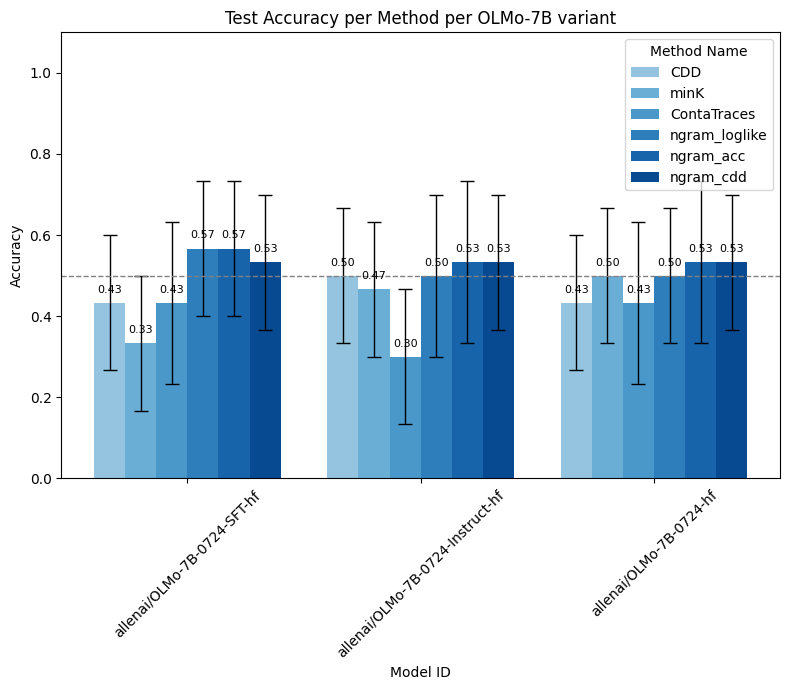

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# Assuming df_sel is your DataFrame

# Drop 'ensemble' methods
df_plot = df_sel[df_sel['method_name'] != 'Ensemble']

# Unique models and methods
models = df_plot['model_id'].unique()
methods = df_plot['method_name'].unique()

# Set up the x positions
x = np.arange(len(models))
width = 0.8 / len(methods)

# Create a blue colormap
colors = cm.Blues(np.linspace(0.4, 0.9, len(methods)))

fig, ax = plt.subplots(figsize=(8, 7))

# Plot each method
for i, method in enumerate(methods):
    method_data = []
    ci_errors = []  # store CI errors
    for model in models:
        row = df_plot[(df_plot['model_id'] == model) & (df_plot['method_name'] == method)]
        if not row.empty:
            acc = row['accuracy'].values[0]
            ci_upper = row['accuracy_95CI_upper'].values[0]
            error = ci_upper - acc  # Half-width of CI
            method_data.append(acc)
            ci_errors.append(error)
        else:
            method_data.append(np.nan)
            ci_errors.append(0)

    bars = ax.bar(x + i * width, method_data, width, label=method, color=colors[i], yerr=ci_errors, capsize=5, error_kw={'elinewidth':1, 'ecolor':'black'})

    # Add text labels
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.02,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8
            )

# Add horizontal dashed line at 0.5
ax.axhline(0.5, color='gray', linestyle='--', linewidth=1)

# Labeling
ax.set_xlabel('Model ID')
ax.set_ylabel('Accuracy')
ax.set_title('Test Accuracy per Method per OLMo-7B variant')
ax.set_xticks(x + width * (len(methods) - 1) / 2)
ax.set_xticklabels(models, rotation=45)

# Set y-axis limits
ax.set_ylim(0, 1.1)  # slightly higher to fit CIs and labels

# Legend
ax.legend(title='Method Name')

plt.tight_layout()
plt.savefig('test_accuracy_plot_olmo7b_variant.pdf', format='pdf', bbox_inches='tight')
plt.show()





### Plots df (test accuracy) to a grouped bar-plot

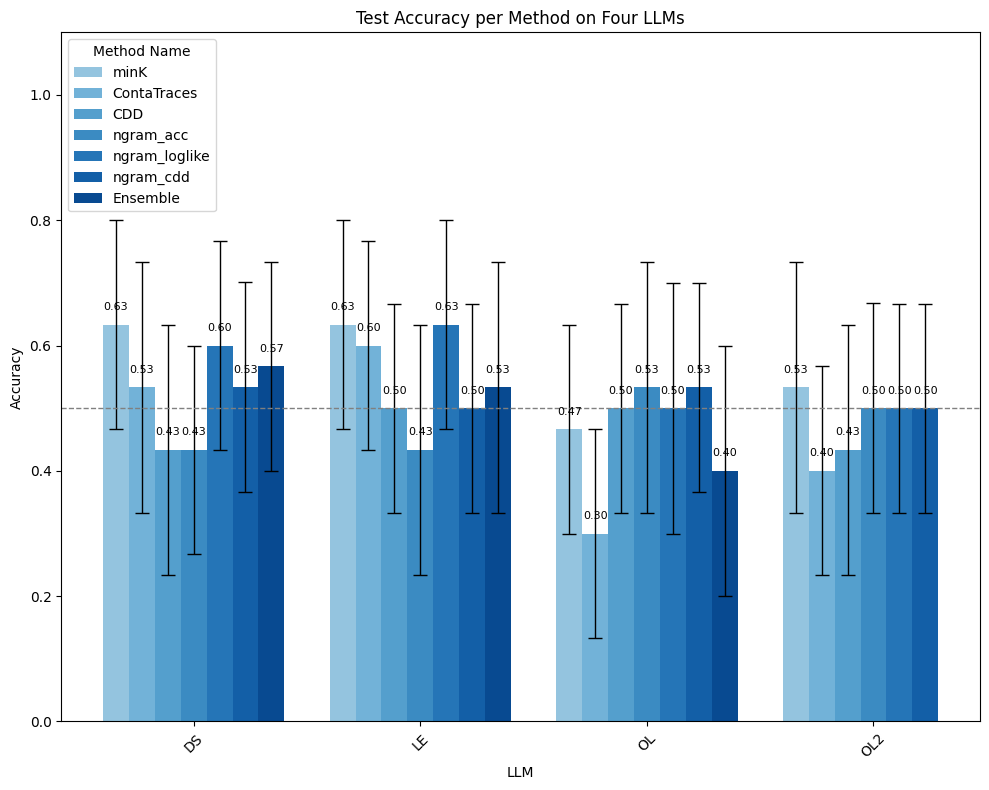

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# Filter and rename models for plotting
df_plot = (
    df_sel[df_sel['model_id'].isin([
        'deepseek-ai/deepseek-math-7b-instruct',
        'EleutherAI/llemma_7b',
        'allenai/OLMo-7B-0724-Instruct-hf',
        'allenai/OLMo-2-1124-13B-Instruct'
    ])]
    .copy()
)

# Rename model IDs
df_plot['model_id'] = df_plot['model_id'].replace({
    'deepseek-ai/deepseek-math-7b-instruct': 'DS',
    'EleutherAI/llemma_7b': 'LE',
    'allenai/OLMo-7B-0724-Instruct-hf': 'OL',
    'allenai/OLMo-2-1124-13B-Instruct': 'OL2'
})

# Enforce specific x-axis order
models = ['DS', 'LE', 'OL', 'OL2']
methods = df_plot['method_name'].unique()

x = np.arange(len(models))
width = 0.8 / len(methods)

colors = cm.Blues(np.linspace(0.4, 0.9, len(methods)))

fig, ax = plt.subplots(figsize=(10, 8))

for i, method in enumerate(methods):
    method_data = []
    ci_errors = []
    for model in models:
        row = df_plot[(df_plot['model_id'] == model) & (df_plot['method_name'] == method)]
        if not row.empty:
            acc = row['accuracy'].values[0]
            ci_upper = row['accuracy_95CI_upper'].values[0]
            error = ci_upper - acc
            method_data.append(acc)
            ci_errors.append(error)
        else:
            method_data.append(np.nan)
            ci_errors.append(0)

    bars = ax.bar(x + i * width, method_data, width, label=method, color=colors[i], yerr=ci_errors, capsize=5, error_kw={'elinewidth':1, 'ecolor':'black'})

    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.02,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8
            )

ax.axhline(0.5, color='gray', linestyle='--', linewidth=1)

ax.set_xlabel('LLM')
ax.set_ylabel('Accuracy')
ax.set_title('Test Accuracy per Method on Four LLMs')
ax.set_xticks(x + width * (len(methods) - 1) / 2)
ax.set_xticklabels(models, rotation=45)

ax.set_ylim(0, 1.1)

ax.legend(title='Method Name')

plt.tight_layout()
plt.savefig('test_accuracy_plot_4LLMs.pdf', format='pdf', bbox_inches='tight')
plt.show()




